# **IMPORTING LIBRARIES AND DATA**

In [347]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
import math
from sklearn.metrics import mean_squared_error

In [368]:
df = pd.read_csv('HEROMOTOCO.csv')

In [369]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-07-31,1845.00,1849.949951,1807.599976,1819.400024,1425.192993,329505.0
1,2013-08-01,1820.00,1832.800049,1798.000000,1815.099976,1421.824707,373538.0
2,2013-08-02,1821.25,1850.000000,1780.050049,1801.800049,1411.406250,251833.0
3,2013-08-05,1803.75,1859.949951,1786.099976,1854.150024,1452.413818,1537397.0
4,2013-08-06,1851.00,1894.900024,1828.199951,1848.199951,1447.753052,370097.0


## **DATA PREPROCESSING**







In [370]:
for i in range(len(df)):
  if numpy.isnan(df.at[i, 'Open']):
    df.drop(i, axis = 0, inplace = True)

In [371]:
DF = df[['Open', 'High', 'Low', 'Close']]
DF.head()

,Open,High,Low,Close
0,1845.00,1849.949951,1807.599976,1819.400024
1,1820.00,1832.800049,1798.000000,1815.099976
2,1821.25,1850.000000,1780.050049,1801.800049
3,1803.75,1859.949951,1786.099976,1854.150024
4,1851.00,1894.900024,1828.199951,1848.199951


# **NORMALIZING FEATURES**

In [372]:
scale_open = MinMaxScaler(feature_range=(0,1))
scale_rest = MinMaxScaler(feature_range=(0,1))
DF_open = scale_open.fit_transform(numpy.array(DF['Open']).reshape(-1,1))
DF_rest = scale_rest.fit_transform(numpy.array(DF[['High', 'Low', 'Close']]).reshape(-1,3))
DF = numpy.concatenate((DF_open, DF_rest), axis = 1)

# **TRAIN-VALID-TEST SPLIT**

In [373]:
valid_percent = 0.15
test_percent = 0.15
train_percent = 1 - (valid_percent + test_percent)

L = len(DF)

train_size = int(train_percent * L)
valid_size = int(valid_percent * L)
test_size = int(test_percent * L)

train_data = DF[0:train_size,:]
valid_data = DF[train_size:train_size + valid_size, :]
test_data = DF[train_size + valid_size:train_size + valid_size + test_size, :]

In [374]:
def create_inout_sequence(input_data, tw):
  input_seq = []
  input_label = []
  L = len(input_data)
  for i in range(L-tw):
    input_seq.append(input_data[i:i+tw,:])
    input_label.append(input_data[i+tw,0])
    
  return numpy.array(input_seq), numpy.array(input_label)

In [375]:
window = 15
X_train, y_train = create_inout_sequence(train_data, window)
X_valid, y_valid = create_inout_sequence(valid_data, window)
X_test, y_test = create_inout_sequence(test_data, window) 

# **MODEL ARCHITECTURE**

In [ ]:
model=Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, dropout = 0.1, input_shape=(X_train.shape[1],4)))
model.add(LSTM(100, activation='relu', return_sequences=False, dropout = 0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [377]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 15, 100)           42000     
_________________________________________________________________
lstm_34 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 122,501
Trainable params: 122,501
Non-trainable params: 0
_________________________________________________________________


In [378]:
model.fit(X_train, y_train, 32, 50, 1, validation_data=(X_valid, y_valid))

Epoch 1/50
38/38 [==============================] - 2s 56ms/step - loss: 0.0538 - val_loss: 0.0021
Epoch 2/50
38/38 [==============================] - 2s 50ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 3/50
38/38 [==============================] - 2s 58ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/50
38/38 [==============================] - 2s 50ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/50
38/38 [==============================] - 2s 48ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 7/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 8/50
38/38 [==============================] - 2s 49ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/50
38/38 [==============================] - 2s 49ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 10/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 11/

# **ACCURACY AND PLOTTING**

In [379]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

In [380]:
train_predict = scale_open.inverse_transform(train_predict)
y_train = scale_open.inverse_transform(y_train.reshape(-1,1))
valid_predict = scale_open.inverse_transform(valid_predict)
y_valid = scale_open.inverse_transform(y_valid.reshape(-1,1))
test_predict = scale_open.inverse_transform(test_predict)
y_test = scale_open.inverse_transform(y_test.reshape(-1,1))

In [381]:
math.sqrt(mean_squared_error(y_train,train_predict))

141.65453181871698

In [382]:
math.sqrt(mean_squared_error(y_valid,valid_predict))

121.34112331997287

In [383]:
math.sqrt(mean_squared_error(y_test,test_predict))

106.44968715202421

In [384]:
lookback = 15
trainpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
trainpredict.shape
trainpredict[:,:] = numpy.nan
trainpredict[lookback:train_size, :] = train_predict

In [385]:
validpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
validpredict[:,:] = numpy.nan
validpredict[train_size + lookback:train_size + valid_size, :] = valid_predict

In [386]:
testpredict = numpy.empty_like(DF[:,0]).reshape(-1,1)
testpredict[:,:] = numpy.nan
testpredict[train_size + valid_size + lookback: -2, :] = test_predict

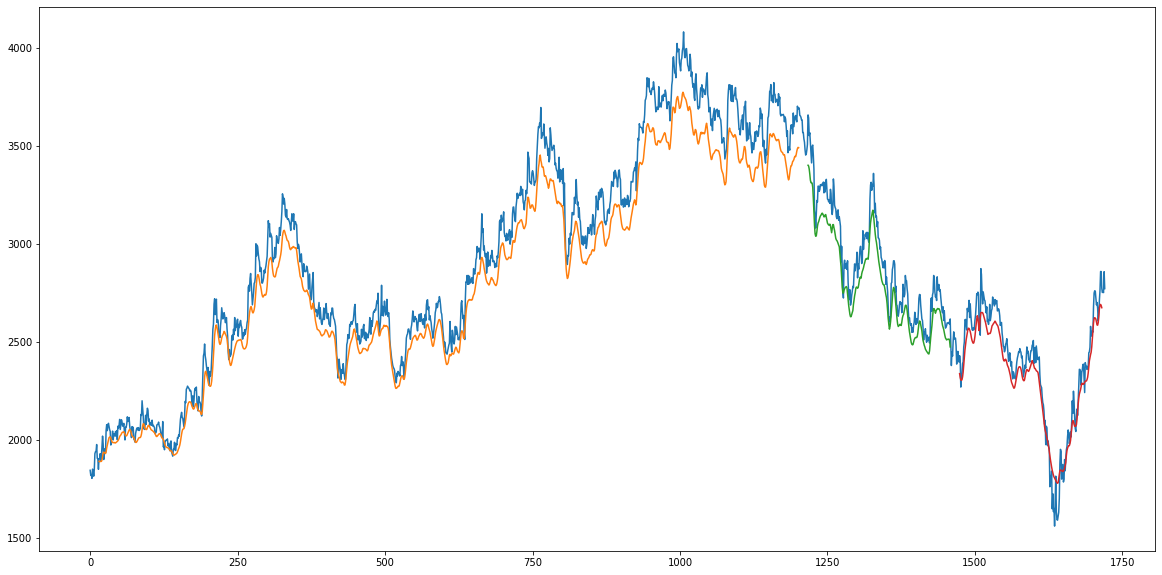

In [387]:
plt.figure(figsize=(20,10))
df['Open'].plot()

plt.plot(trainpredict)
plt.plot(validpredict)
plt.plot(testpredict)